In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
%%time

mice = Mice((192, 4), full_load=True, load_allen=True)

[PROGRESS] 'config.json' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-columnar_n-192*4

ROI lookup not found, time to run organize func.

combine metadata not found, time to run cat_data() . . .

CPU times: user 3.8 s, sys: 633 ms, total: 4.43 s
Wall time: 17.8 s


In [ ]:
%%time

mice.parcel.fit_parcel(True, cutoff=3)

[PROGRESS] fit columnar: initiated

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [ ]:
from register.register import Register
reg = Register(mice)
reg.register_anat(True)

In [3]:
%timeit Mice((128, 2))

1.15 s ± 81 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
list(mice.parcel.results)

[
    'radius',
    'cutoff',
    'shape_parcel2d-flat',
    'shape_parcel2d-top',
    'shape_parcel3d',
    'nonzero-idxs_parcel2d-flat',
    'nonzero-idxs_parcel2d-top',
    'nonzero-idxs_parcel3d',
    'region-idxs_parcel2d-flat',
    'region-idxs_parcel2d-top',
    'region-idxs_parcel3d'
]

In [6]:
%%time

mice.setup_func_data()

CPU times: user 225 ms, sys: 121 ms, total: 346 ms
Wall time: 374 ms


## Hier Ca

In [7]:
hier = Hierarchical(mice, 'sub-SLC', 'ca2').fit_hierarchical(range(3, 11))

In [8]:
list(hier.results)

[3, 4, 5, 6, 7, 8, 9, 10]

In [9]:
pi_disjoint = np.zeros((len(hier.results), len(hier.n2l)), dtype='uint32')

for i, (n_clust, result_d) in enumerate(hier.results.items()):
    for oc_idx, clist in result_d['cluster_assigns'].items():
        for lbl in clist:
            node = hier.l2n[lbl]
            pi_disjoint[i, node] = oc_idx

In [10]:
proj = hier.project_vec(pi_disjoint)

In [11]:
import ants

topview = 'topview_10um.nii.gz'
topview = pjoin(mice.cfg.base_dir, topview)
topview = ants.image_read(topview, pixeltype='unsigned int')
topview = topview.numpy()

flatmap = 'flatmap_10um.nii.gz'
flatmap = pjoin(mice.cfg.base_dir, flatmap)
flatmap = ants.image_read(flatmap, pixeltype='unsigned int')
flatmap = flatmap.numpy()

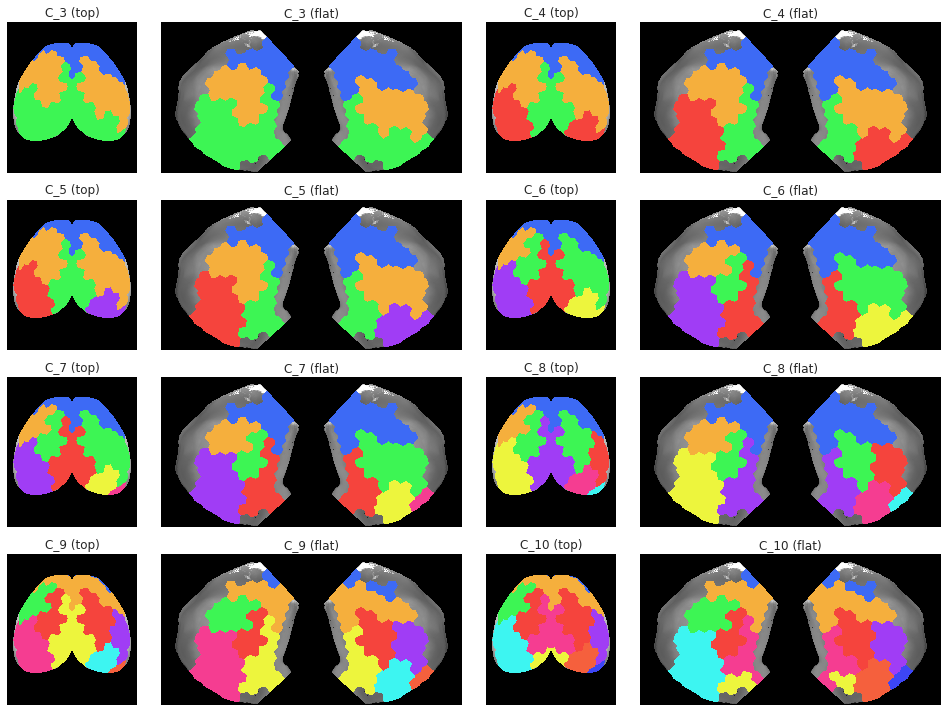

In [12]:
ncols = 4
nrows = int(np.ceil(len(hier.results) / (ncols / 2)))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

min_thres = 0.1

for i, n_clust in enumerate(hier.results):
    cmap = get_cluster_cmap(range(n_clust))
    data_top = proj['parcel2d-top'][i]
    data_flat = proj['parcel2d-flat'][i]

    data2plt = np.ma.masked_where(data_top < min_thres, data_top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(f"C_{n_clust} (top)")

    data2plt = np.ma.masked_where(data_flat < min_thres, data_flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(f"C_{n_clust} (flat)")

trim_axs(axes, 2 * len(hier.results))
remove_ticks(axes)
plt.show()

## Hier BOLD

In [7]:
hier = Hierarchical(mice, 'sub-SLC', 'bold').fit_hierarchical(range(3, 11))

In [8]:
pi_disjoint = np.zeros((len(hier.results), len(hier.n2l)), dtype='uint32')

for i, (n_clust, result_d) in enumerate(hier.results.items()):
    for oc_idx, clist in result_d['cluster_assigns'].items():
        for lbl in clist:
            node = hier.l2n[lbl]
            pi_disjoint[i, node] = oc_idx

In [9]:
proj = hier.project_vec(pi_disjoint)

In [10]:
list(proj)

['parcel3d']

In [12]:
proj['parcel3d'][1].shape

(1320, 800, 1140)

<matplotlib.image.AxesImage object at 0x7f8100437370>

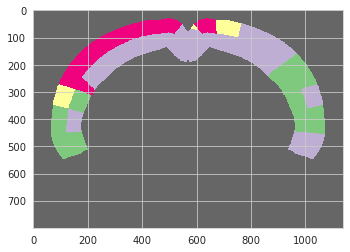

In [22]:
plt.imshow(proj['parcel3d'][1][660], cmap='Accent_r')

<matplotlib.image.AxesImage object at 0x7f7f99244520>

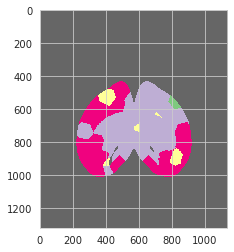

In [29]:
plt.imshow(proj['parcel3d'][1][:, 100, :], cmap='Accent_r')

In [14]:
min_thres = 0.1

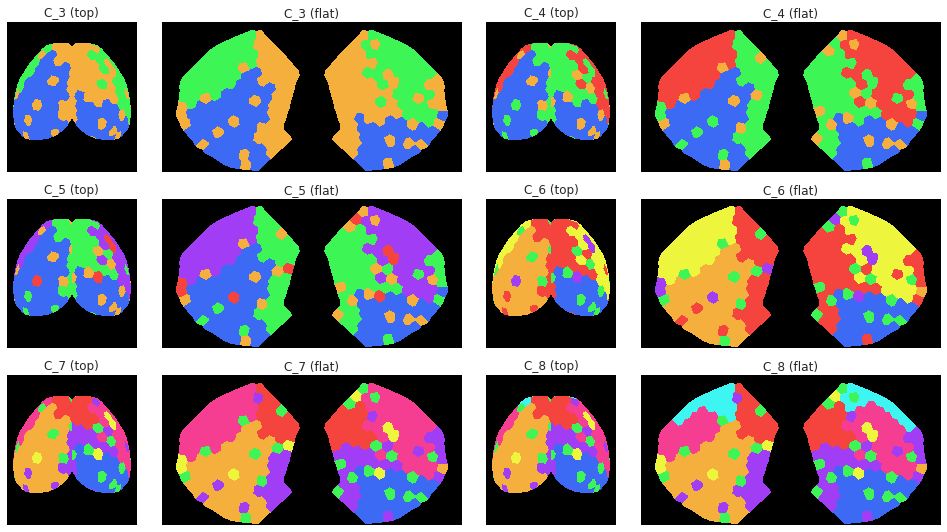

In [15]:
ncols = 4
nrows = int(np.ceil(len(hier.results) / (ncols / 2)))
fig, axes = create_figure(nrows, ncols, (13.5, 2.5 * nrows), gridspec_kw={'width_ratios': [1, 2, 1, 2]})

for i, n_clust in enumerate(hier.results):
    cmap = get_cluster_cmap(range(n_clust))
    data_top = proj['parcel2d-top'][i]
    data_flat = proj['parcel2d-flat'][i]

    data2plt = np.ma.masked_where(data_top < min_thres, data_top)
    ax = axes.ravel()[i * 2]
    ax.imshow(topview, cmap='Greys_r')
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(f"C_{n_clust} (top)")

    data2plt = np.ma.masked_where(data_flat < min_thres, data_flat)
    ax = axes.ravel()[i * 2 + 1]
    ax.imshow(flatmap, cmap='Greys_r')
    ax.imshow(data2plt, cmap=cmap)
    ax.set_title(f"C_{n_clust} (flat)")

trim_axs(axes, 2 * len(hier.results))
remove_ticks(axes)
plt.show()

In [ ]:
plt.imshow(proj['parcel3d'][400])

In [ ]:
%%time

net_ca = Network(
    mice=mice,
    key='sub-SLC',
    df=mice.ca_dfs['sub-SLC'],
    percentiles=np.linspace(50, 1, 50),
).fit_network(save=False)

In [ ]:
%%time

net_bold = Network(
    mice=mice,
    key='sub-SLC',
    df=mice.bold_dfs['sub-SLC'],
    percentiles=np.linspace(50, 1, 50),
).fit_network(save=False)

In [ ]:
sns.histplot(net_ca.adj[net_ca.adj.nonzero()], color='C0', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

sns.histplot(net_bold.adj[net_bold.adj.nonzero()], color='C1', alpha=0.5, stat='density')
plt.axvline(net_bold.thresholds[10], color='g', ls=':')
plt.axvline(net_bold.thresholds[5], color='r', ls=':')

plt.show()

In [ ]:
x = mice.ca_dfs['sub-SLC'].values
x.shape

In [ ]:
nans = np.where(np.isnan(x).sum(0) > 0)[0]
x = np.delete(x, nans, axis=1)
x.shape

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(
    n_components=100,
    svd_solver='full',
).fit(x)

In [ ]:
plt.plot(pca.explained_variance_ratio_)

In [ ]:
pca.components_.shape

In [ ]:
y = pca.transform(x)
y.shape

In [ ]:
plt.plot(y[:, 0])

In [ ]:
np.where(y[:, 0] > 100)[0]

In [ ]:
i = 21999
plt.imshow(x[i-150:i+150].T)

In [ ]:
i = 21999
plt.imshow(x[i-10:i+10].T, aspect=0.2)
plt.colorbar()

In [ ]:
plt.plot(np.abs(x).mean(-1))

In [ ]:
z = y.copy()
z[:, 0] = 0

x_inv = pca.inverse_transform(z)
x_inv.shape

In [ ]:
df_new = pd.DataFrame(x_inv)
df_new.shape

In [ ]:
a, p = get_adj_mat(df_new, 'pearson')

In [ ]:
plt.imshow(a)
plt.colorbar()

In [ ]:
plt.imshow(net_ca.adj)
plt.colorbar()

In [ ]:
sns.histplot(net_ca.adj[net_ca.adj.nonzero()], color='C0', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

sns.histplot(a[a.nonzero()], color='C5', alpha=0.5, stat='density')
plt.axvline(net_ca.thresholds[10], color='g', ls='--')
plt.axvline(net_ca.thresholds[5], color='r', ls='--')

In [ ]:
plt.imshow(a)
plt.colorbar()

In [ ]:
th = np.quantile(a.ravel(), q=0.8)

a_gsr = a.copy()
a_gsr[a > th] = 1.0
a_gsr[a <= th] = 0.0

In [ ]:
th = np.quantile(net_ca.adj.ravel(), q=0.8)

a_full = net_ca.adj.copy()
a_full[net_ca.adj > th] = 1.0
a_full[net_ca.adj <= th] = 0.0

In [ ]:
plt.imshow(a_gsr)

In [ ]:
plt.imshow(a_full)

In [ ]:
a_full2 = np.delete(np.delete(a_full, nans, axis=0), nans, axis=1)

In [ ]:
plt.imshow(a_full2)

In [ ]:
df = mice.ca_dfs['sub-SLC'].copy()
df[df.isnull()] = 0

In [ ]:
df

In [ ]:
hier = Hierarchical(mice, 'sub-SLC', df)

In [ ]:
hier.fit(5)

In [ ]:
_ = hier.fit(7)

In [ ]:
hier.results[7]['cluster_assigns']

In [ ]:
"""cluster_assigns = hier.results[5]['cluster_assigns']
cluster_assigns = {
    c_idx: [
        mice.parcel.encode(*tuple(map(
            lambda string: int(string),
            net_ca.n2l[e].split('-'))))
        for e in c_list]
    for c_idx, c_list in cluster_assigns.items()
}
cluster_assigns"""

In [ ]:
_ = hier.fit(7)

In [ ]:
results = get_pdist(, 'correlation')

In [ ]:
list(results)

In [ ]:
results['y']

In [ ]:
x = mice.ca_dfs['sub-SLC01_ses-1_run-1'].values
x = np.ma.masked_where(~np.isfinite(x), x)
x.shape

In [ ]:
y = sp_dist.pdist(x.T, metric='correlation')

In [ ]:
y, len(y)

In [ ]:
from nancorrmp.nancorrmp import NaNCorrMp

In [ ]:
mice.ca_dfs['sub-SLC01_ses-1_run-1'].reset_index(drop=True).to_dict().items()

In [ ]:
a = NaNCorrMp.calculate,(x)

In [ ]:
a.shape

In [ ]:
plt.imshow(a)

In [ ]:
from analysis.hierarchical import sp_hier


In [ ]:
yy = results['y'].copy()
yy = np.ma.masked_where(~np.isfinite(yy), yy)
sp_hier.linkage(yy)

In [ ]:
y = results['y'].copy()
np.isfinite(y)

In [ ]:
sp_hier.linkage(np.random.randn(10))

In [ ]:
net.thresholds

In [ ]:
plt.imshow(net.adjacencies[31], cmap=net.style['cmap'])
plt.colorbar()

In [ ]:
list(net.adjacencies)

In [ ]:
x = net.adjacencies[10].copy()
x[x.nonzero()] = 1
plt.imshow(x, cmap=net.style['cmap'])
plt.show()

In [ ]:
plt.imshow(net.adjacencies[10], cmap=net.style['cmap'])
plt.show()

In [ ]:
plt.imshow(net.adjacencies[10], cmap=net.style['cmap'])
plt.show()

In [ ]:
list(net.l2n)[:15]

In [ ]:
plt.imshow(net.adjacencies[10][:15][:, :15], cmap=net.style['cmap'])
plt.show()

In [ ]:
net.set_percentiles(np.linspace(39, 1, 39), fit=False)

In [ ]:
net._apply_thresholds()

In [ ]:
net.thresholds

In [ ]:
sns.histplot(net.adj[net.adj.nonzero()], color='C0')
plt.axvline(net.thresholds[10], color='g', ls='--')
plt.axvline(net.thresholds[5], color='r', ls='--')

In [ ]:
x = net.adjacencies[25].copy()
x[x.nonzero()] = 1
plt.imshow(x, cmap=net.style['cmap'])
plt.show()

In [ ]:
df_stim = mice.load_stim_times('ca2')
df_stim

In [ ]:
_df = df_stim.loc[df_stim['stim'] == 1]
_df = _df[_df['task'].values == 'rest']
_df

In [ ]:
_df['key'].unique()

In [ ]:
df_stim = mice.load_stim_times('bold')
df_stim

In [ ]:
save_obj(dfs, 'test_ca', tmp_dir, 'npy')

In [ ]:
list(dfs)

In [ ]:
dfs['sub-SLC08_ses-2_run-6']

In [ ]:
x = dfs['sub-SLC08_ses-2_run-6'].corr()
x = x.values
np.fill_diagonal(x, 0.)

In [ ]:
plt.imshow(x)

In [ ]:
x.shape

In [ ]:
a, p = get_adj_mat(dfs['sub-SLC08_ses-2_run-6'], 'pearson')
aa, pp = get_adj_mat(dfs['sub-SLC08_ses-2_run-6'], 'spearman')

In [ ]:
idxs_pears = np.where(np.abs(a).sum(0) == 0)[0]
idxs_spear = np.where(np.abs(aa).sum(0) == 0)[0]

In [ ]:
a.shape, aa.shape

In [ ]:
fig, axes = create_figure(1, 2, (12, 4.5))

vminmax = np.max(np.abs(a))
im = axes[0].imshow(a, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=axes[0])

vminmax = np.max(np.abs(aa))
im = axes[1].imshow(aa, cmap='bwr', vmin=-vminmax, vmax=vminmax)
plt.colorbar(im, ax=axes[1])

In [ ]:
sns.histplot(a[a.nonzero()], color='C0', alpha=0.5)
sns.histplot(aa[aa.nonzero()], color='C1', alpha=0.5)

In [ ]:
node_labels = dfs['sub-SLC08_ses-2_run-6'].columns.values

In [ ]:
node_labels

In [ ]:
n2l = {i: lbl for i, lbl in enumerate(node_labels)}
l2n = {lbl: i for i, lbl in n2l.items()}

In [ ]:
n2l

In [ ]:
dfs = mice.make_dfs('ca2')

In [ ]:
y = dfs['sub-SLC08_ses-2_run-6'].corr()
y = y.values
np.fill_diagonal(y, 0.)

In [ ]:
plt.imshow(y)

In [ ]:
np.isnan(y).sum(1)

In [ ]:
aaa = np.where(np.isnan(y).sum(1) > 100)[0]
aaa

In [ ]:
bbb = dfs['sub-SLC08_ses-2_run-6'].columns[aaa]
bbb

In [ ]:
ca_func = mice.ca['sub-SLC08_ses-2_run-6'].get_data()

In [ ]:
{k: v for k, v in ca_func.items() if k in bbb}

In [ ]:
sns.histplot(perc_missing.values())

In [ ]:
mice.setup_func_data()

In [ ]:
x = mice.ca['sub-SLC01_ses-2_run-3'].get_data()

In [ ]:
list(x)

In [ ]:
def _reindex_fn(s):
    vals = tuple(map(lambda e: int(e), s.split('-')))
    i = int(vals[0] * 2e9) + vals[-1]
    if len(vals) == 3:
        i += int(vals[1] * 10)
    return i + int(6e6 / len(vals))

In [ ]:
sorted(x, key=_reindex_fn)

In [ ]:
from register.register import Register
reg = Register(mice)

In [ ]:
reg.organize_func(0.1)

In [ ]:
reg.set_mode('3d')
acc = reg.get_accepted_regions(0.1)
{k: len(v) for k, v in acc.items()}

In [ ]:
cor3d = acc['cortex-merged']

In [ ]:
reg.set_mode('2d')
acc2 = reg.get_accepted_regions(0.1)
{k: len(v) for k, v in acc2.items()}

cor2d = acc2['cortex-merged']

In [ ]:
[i for i in cor2d if i not in cor3d]

In [ ]:
thres = 0.1

regions_all = {}
for sub in mice.cfg.sub_ids:
    for ses in mice.cfg.ses_ids:
        key = mice.get_key(sub, ses)
        mask = mice.mask3d[key].load_ants('unsigned int')
        mask = mask.numpy().astype(bool)
        obj = reg.load_obj_masks(key)
        x = obj['cortex-merged'].numpy()
        x *= mask
        regions = np.unique(x[x.nonzero()])
        regions_all[key] = sorted(regions)

regions_agg = []
for item in regions_all.values():
    regions_agg += item
freq = collections.Counter(regions_agg)
freq = {
    i: v / len(regions_all)
    for i, v in freq.items()
}
freq = {
    i: freq.get(i, 0.0) for i in
    mice.parcel.complement(list(freq))
}

rej = dict(filter(
    lambda t: t[1] < thres,
    freq.items()
))
rej = mice.parcel.complement(sorted(rej))
acc = [
    i for i in freq
    if i not in rej
]

msg = '\n\n'
msg += f"Name: {'cortex-merged'} . . . a total of {len(acc)} regions were accepted.\n"
msg += f"accept ratio: {100 * len(acc) / len(freq):0.0f} %, "
msg += f"reject ratio: {100 * len(rej) / len(freq):0.0f} %, "
msg += f"using a presence threshold of {0.1 * 100} %\n"

print(msg)

In [ ]:
sns.ecdfplot(freq.values())

In [ ]:

list(obj)

In [ ]:
regions_all = {}


In [ ]:
from register.register import Register
reg = Register(mice)

In [ ]:
reg.register_anat(True)

In [ ]:
reg.organize_func()

In [ ]:
path = '/home/hadi/Documents/workspaces/allen/MouseConnectivity/cortical_coordinates'
sorted(os.listdir(path))

In [ ]:
laplacian, laplacian_header = nrrd.read(pjoin(path, 'laplacian_10.nrrd'))

In [ ]:
laplacian.shape

In [ ]:
laplacian_header

In [ ]:
plt.imshow(laplacian[600], cmap='turbo')

In [ ]:
boundary, boundary_header = nrrd.read(pjoin(path, 'isocortex_boundary_10.nrrd'))

In [ ]:
import h5py

In [ ]:
with h5py.File(pjoin(path, 'top_view_paths_10.h5'), 'r') as f:
    paths = np.array(f['paths'])
    view = np.array(f['view lookup'])
paths.shape, view.shape

In [ ]:
plt.imshow(view)
plt.colorbar()

In [ ]:
with h5py.File(pjoin(path, 'dorsal_flatmap_paths_10.h5'), 'r') as f:
    dorsal_paths = np.array(f['paths'])
    dorsal_view = np.array(f['view lookup'])
dorsal_paths.shape, dorsal_view.shape

In [ ]:
plt.imshow(dorsal_view)